# Crime Monthly Rhythm Maps

This is an alternative version of the "Crime Monthly Rhythm Maps" that uses a Sqlite database instead of a CSV file. 

In [1]:
%matplotlib inline
%run crimelib.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sdipylib.url import download_ambry_db # install: pip install 'git+https://github.com/sdrdl/sdipylib.git'

download_ambry_db('http://s3.sandiegodata.org/library/clarinova.com/crime-incidents-casnd-linked-0.1.2/crimes.db')
download_ambry_db('http://s3.sandiegodata.org/library/clarinova.com/places-casnd-0.1.7/areastats.db')

Downloading: http://s3.sandiegodata.org/library/clarinova.com/crime-incidents-casnd-linked-0.1.2/crimes.db
Extracting to: crimes.db
Downloading: http://s3.sandiegodata.org/library/clarinova.com/places-casnd-0.1.7/areastats.db
Extracting to: areastats.db


In [2]:
import sqlite3
conn = sqlite3.connect('crimes.db')
cur = conn.cursor()
 
cur.execute("attach 'areastats.db' as placestats")

In [3]:
q = """
SELECT crimes.*, 
    strftime('%W', datetime) AS week,
    strftime('%M', datetime) AS min,
    
    city_stats.pop as city_pop, city_stats.land as city_area, 
    CAST(city_stats.pop AS REAL)/ CAST(city_stats.land AS REAL) as city_density,
    community_stats.pop as community_pop, community_stats.land as community_area, community_stats.name as community_name, 
    CAST(community_stats.pop AS REAL)/ CAST(community_stats.land AS REAL)*1000000 as community_density 
FROM crimes
LEFT JOIN placestats.areastats AS city_stats ON city_stats.type = 'city' AND city_stats.code = crimes.city
LEFT JOIN placestats.areastats AS community_stats ON community_stats.type = 'community' AND community_stats.code = crimes.community
WHERE community != '-'
"""

inct = pd.read_sql(q, conn)


In [4]:
inct.head()

,id,agency,legend,description,type,datetime,year,month,hour,dow,...,geometry,week,min,city_pop,city_area,city_density,community_pop,community_area,community_name,community_density
0,38,"San Diego Police, CA",FRAUD,FRAUD,CRIME CASE,2007-01-01 00:00:00.000000,2007,1,0,1,...,None,01,00,None,None,None,47361,15434818,"Encanto Neighborhoods,Southeastern",3068.452119
1,39,"San Diego Police, CA",FRAUD,FRAUD,CRIME CASE,2007-01-01 00:00:00.000000,2007,1,0,1,...,None,01,00,None,None,None,39849,10511946,Pacific Beach,3790.829976
2,40,"San Diego Police, CA",FRAUD,FRAUD,CRIME CASE,2007-01-01 00:00:00.000000,2007,1,0,1,...,None,01,00,None,None,None,48313,34788640,Navajo,1388.757939
3,41,"San Diego Police, CA",FRAUD,FRAUD,CRIME CASE,2007-01-01 00:00:00.000000,2007,1,0,1,...,None,01,00,None,None,None,29018,22008803,La Jolla,1318.472431
4,42,"San Diego Police, CA",VANDALISM,VANDALISM ($400 OR MORE),CRIME CASE,2007-01-01 00:00:00.000000,2007,1,0,1,...,None,01,00,None,None,None,18947,12621902,Mission Valley,1501.120829


In [5]:
inct['dtime'] = inct['hour'].astype('float64') + inct['min'].astype('float64')/60.0 # Decimal time
inct['qtime'] = (inct['dtime'] * 4).astype('int') # time in 15 minute intervals

In [6]:
list(inct['legend'].unique())
legends = [u'ASSAULT',u'ROBBERY',u'VEHICLE BREAK-IN/THEFT', u'BURGLARY',
        u'THEFT/LARCENY',u'SEX CRIMES',u'DRUGS/ALCOHOL VIOLATIONS',u'DUI']

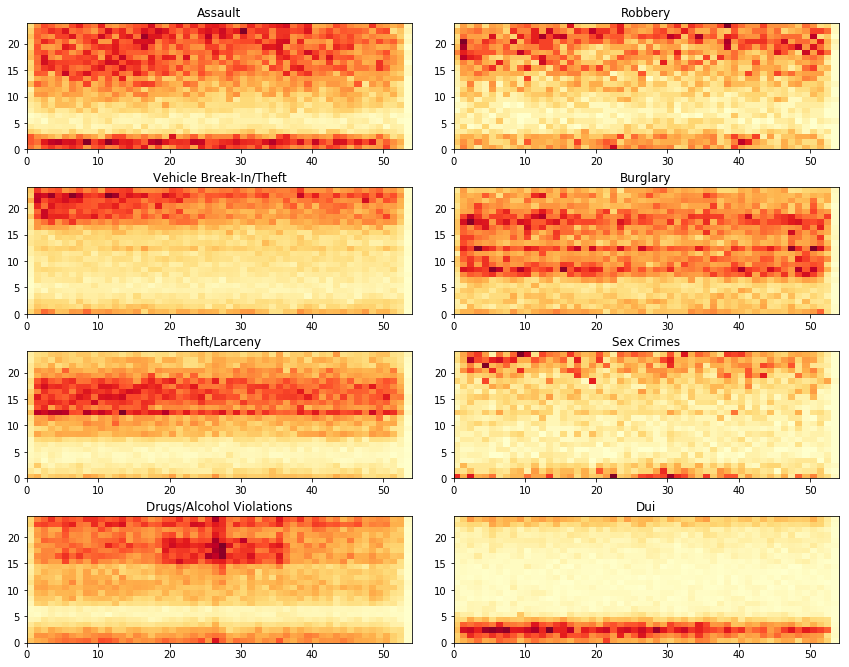

In [7]:
plot_rhythm(inct, ncols = 2, axes_fields=['hour','week'], legends=legends)

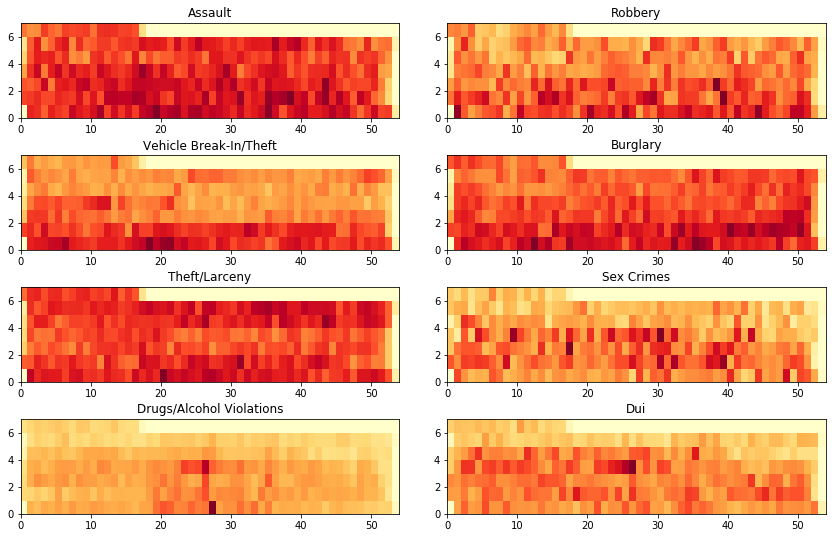

In [8]:
plot_rhythm(inct, ncols = 2, axes_fields=['year','week'], legends=legends, height=2)

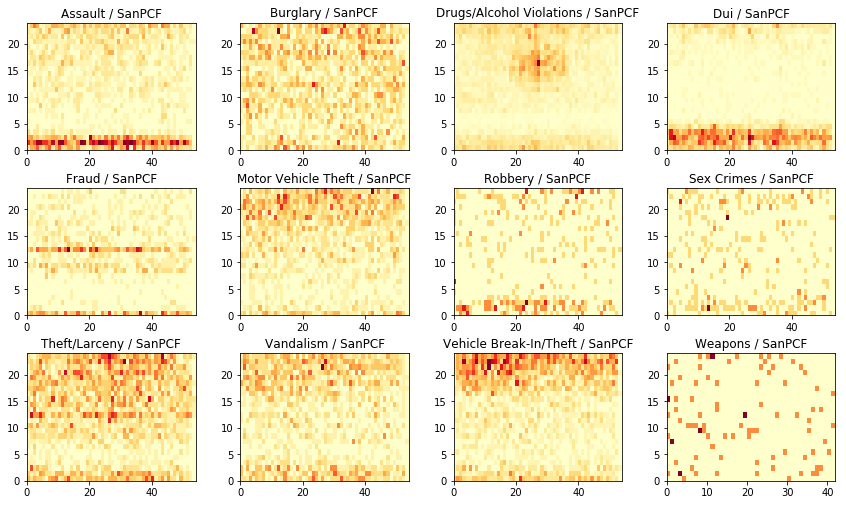

In [9]:
plot_rhythm(inct, ncols = 4, communities = ['SanPCF'], axes_fields=['hour','week'])

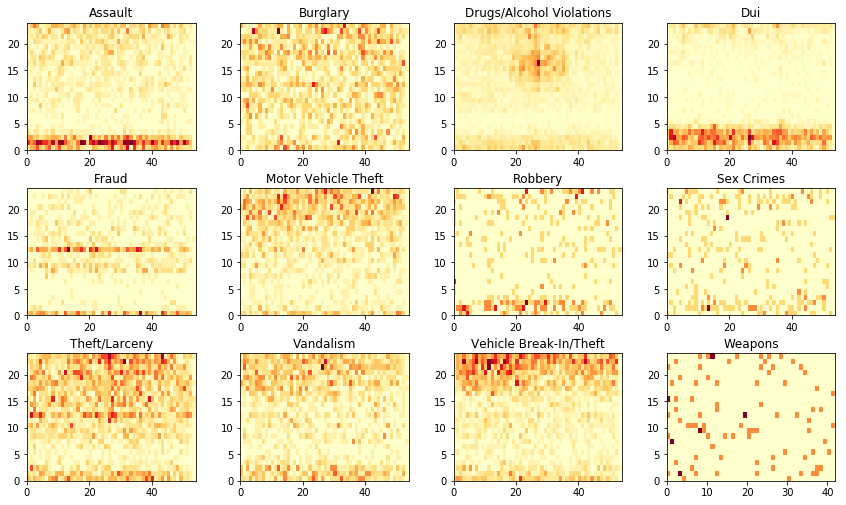

In [10]:
plot_rhythm(inct[inct.community == 'SanPCF'], ncols = 4, axes_fields=['hour','week'])

In [11]:
communities = ['SanDOW','SanMDC','SanPCF','SanSOT','SanGRE','SanCLA','SanUPT','SanENC','SanUNV','SanMID',
               'SanMIR','SanSKY','SanOAT', 'SanCOL', 'SanLAJ']
all_communities = list(inct['community'].unique())
drug_communities = ['SanPCF','SanMSS','SanUNV','SanMSH','SanOCN','SanMIS']
assault_communities = ['SanENC', 'SanMDC', 'SanPCF', 'SanDOW', 'SanGRE']
sex_communities = ['SanDOW', 'SanMDC', 'SanGRE', 'SanCOL', 'SanMDS', 'SanBAR' ]

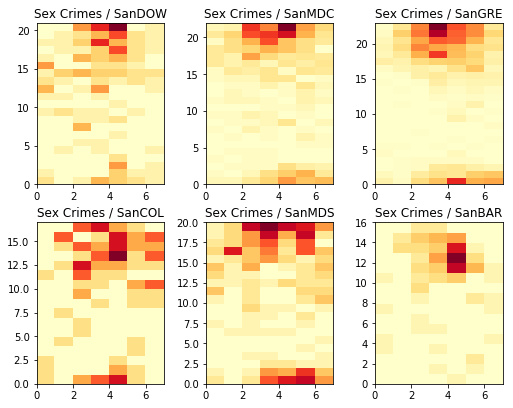

In [12]:
plot_rhythm(inct[inct.description == 'PROSTITUTION' ], ncols = 3, height=5, scale = .6, 
            legends = ['SEX CRIMES'], 
            communities=sex_communities, axes_fields=['hour','dow'])

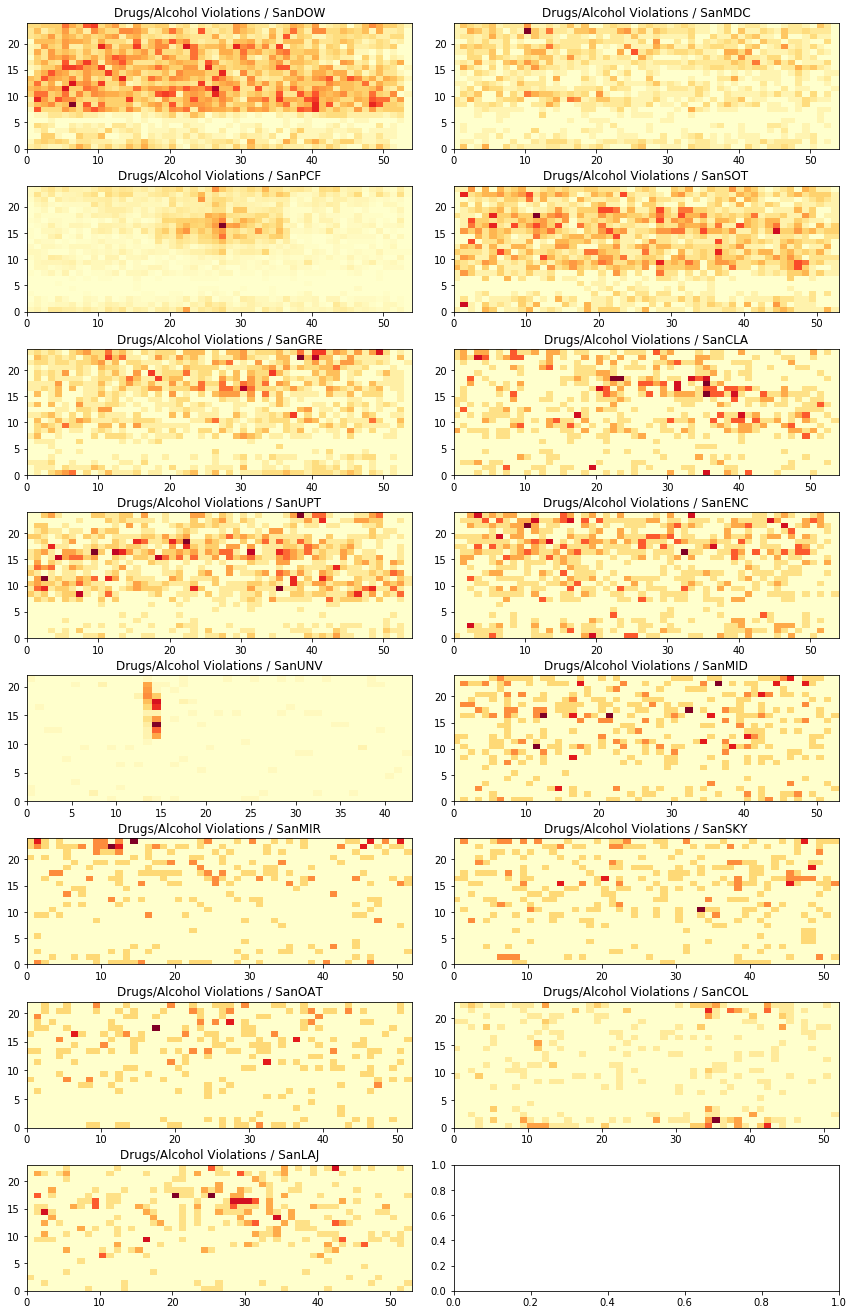

In [13]:
plot_rhythm(inct, ncols = 2, legends = ['DRUGS/ALCOHOL VIOLATIONS'], communities=communities, 
            axes_fields=['hour','week'], incident_type='CITATION')

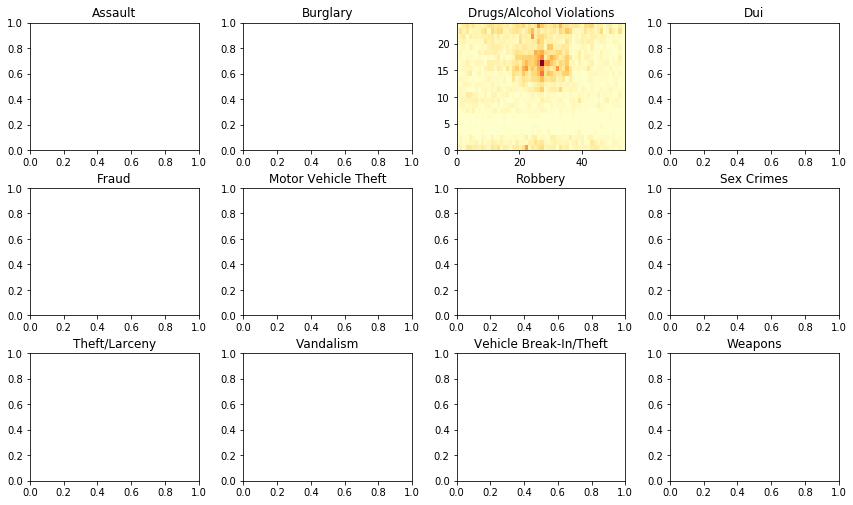

In [14]:
plot_rhythm(inct[inct.community == 'SanPCF'], ncols = 4, axes_fields=['hour','week'], incident_type='CITATION')

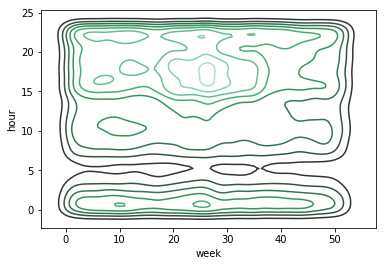

In [15]:
import seaborn as sns

x = inct[inct.legend == 'DRUGS/ALCOHOL VIOLATIONS']

sns.kdeplot(x.week, x.hour);


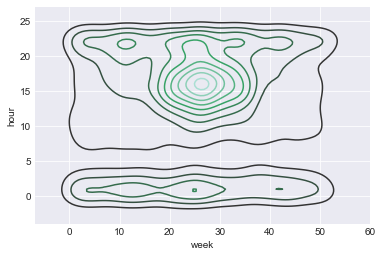

In [16]:
x = inct[(inct.legend == 'DRUGS/ALCOHOL VIOLATIONS') & (inct.community == 'SanPCF')]
sns.set_style("darkgrid")
sns.kdeplot(x.week, x.hour);

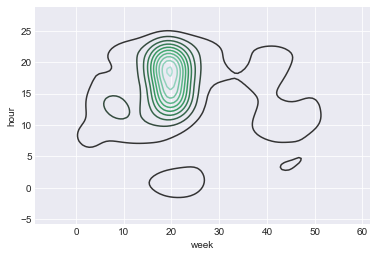

In [17]:
x = inct[(inct.legend == 'DRUGS/ALCOHOL VIOLATIONS') & (inct.community == 'SanUNV')]

sns.kdeplot(x.week, x.hour);

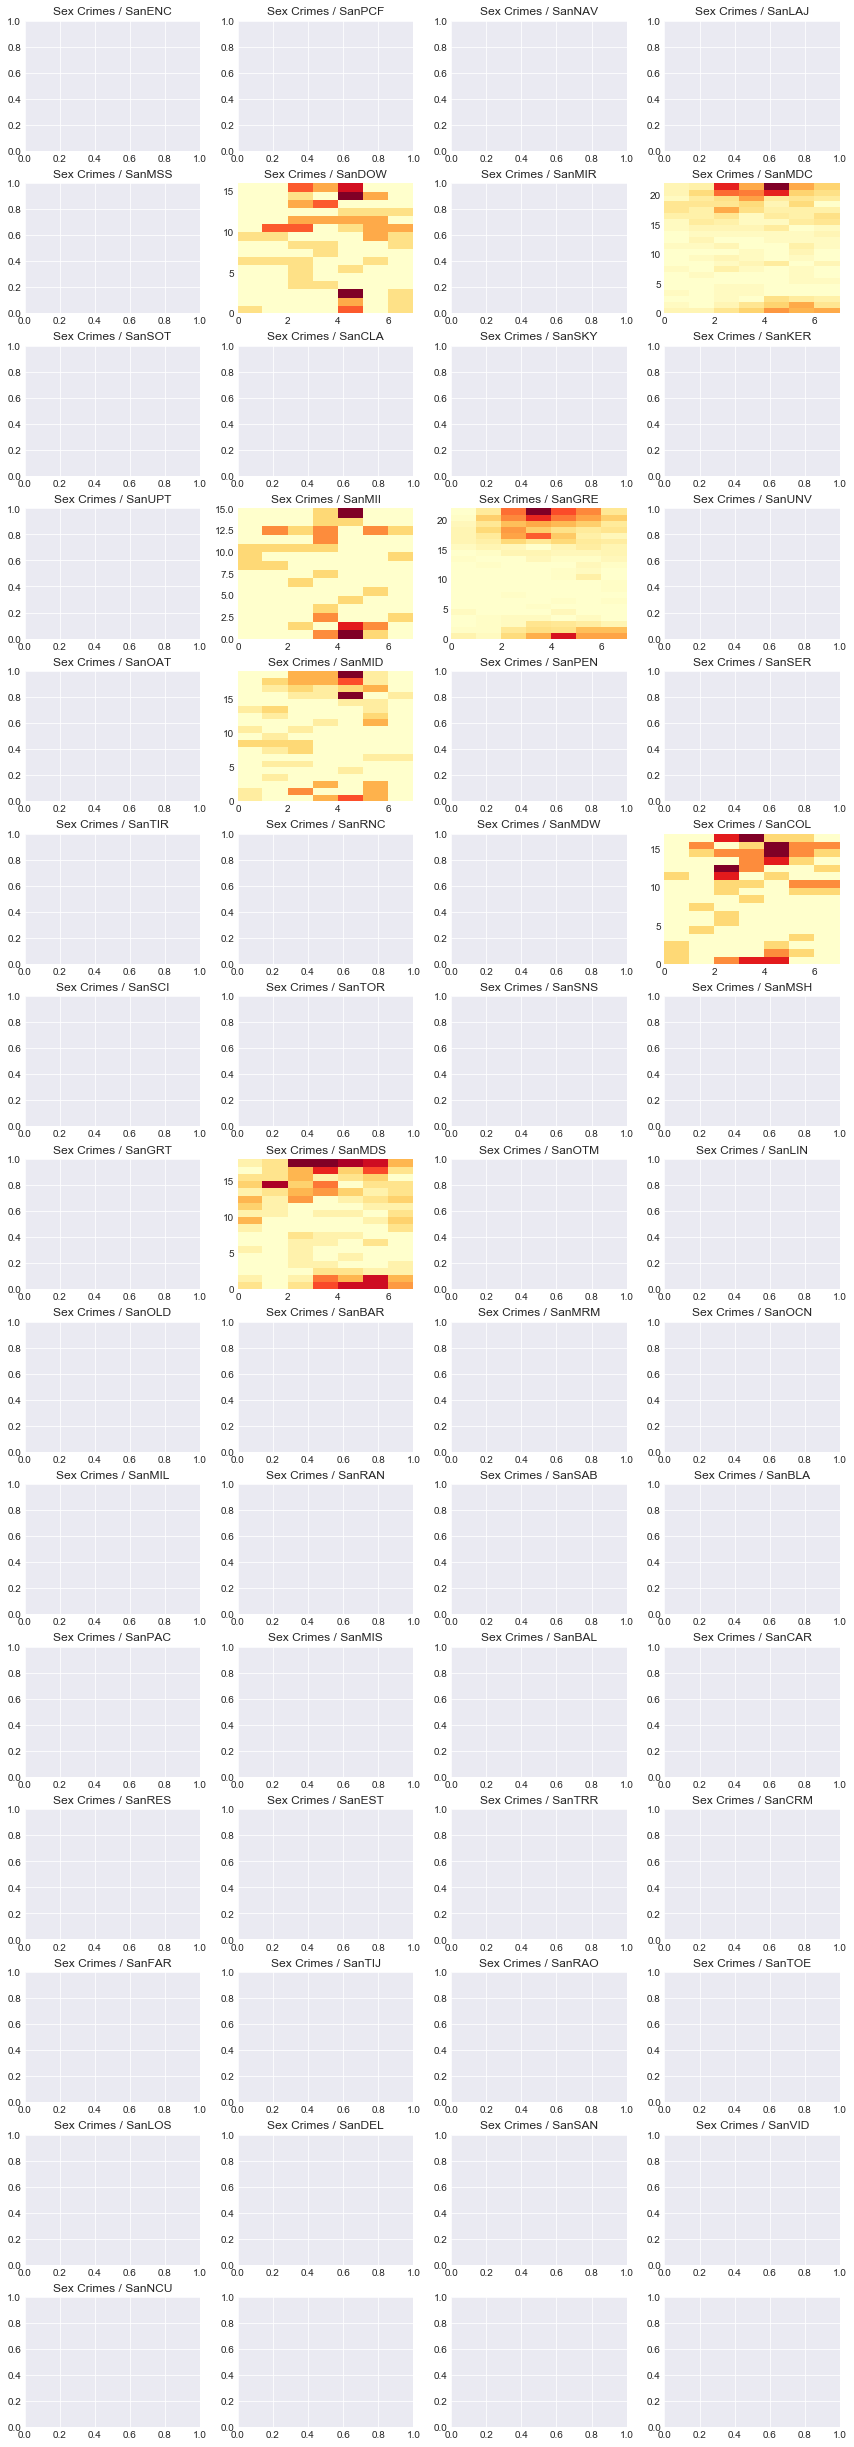

In [18]:
plot_rhythm(inct, ncols = 4, legends = ['SEX CRIMES'], communities=all_communities, 
            axes_fields=['hour','dow'], incident_type='ARREST')

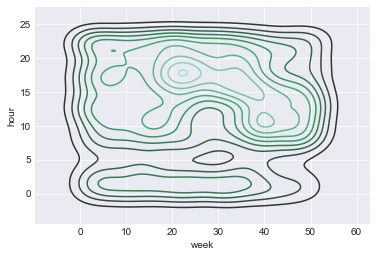

In [19]:
x = inct[(inct.legend == 'DRUGS/ALCOHOL VIOLATIONS') & (inct.community == 'SanCLA')]

sns.kdeplot(x.week, x.hour);

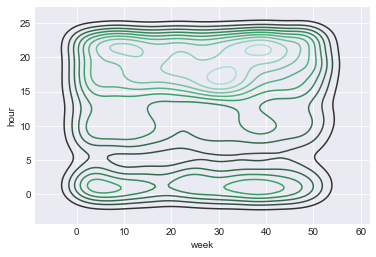

In [20]:
x = inct[(inct.legend == 'DRUGS/ALCOHOL VIOLATIONS') & (inct.community == 'SanGRE')]

sns.kdeplot(x.week, x.hour);